In [1]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm_notebook as tqdm

import Discriminators
import Generators
import Eval
import Utils

In [2]:
# Execution Parameters
data_dir = './Data'
cache_dir = './Cache'
checkpoint_dir = './Checkpoints'
gpgpu_dev = 'cuda:0'

In [3]:
# Load CIFAR-10 Dataset from Torchvision and Normalize Data to [0,1]
train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True)
train_x = torch.FloatTensor(np.transpose(train_set.data, [0, 3, 1, 2])) / 255
train_y = F.one_hot(torch.LongTensor(np.asarray(train_set.targets)), 10).float()

test_set = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True)
test_x = torch.FloatTensor(np.transpose(test_set.data, [0, 3, 1, 2])) / 255
test_y = F.one_hot(torch.LongTensor(np.asarray(test_set.targets)), 10).float()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Training Parameters

# Tensor Shape Information
noise_channels = 90
image_channels = train_x.shape[1]

# Dataset Sizes
train_size = train_x.shape[0]
test_size = test_x.shape[0]

# Optimizer Hyperparameters
gen_lr = 0.0001
gen_beta1 = 0.0
gen_beta2 = 0.999

disc_lr = 0.0004
disc_beta1 = 0.0
disc_beta2 = 0.999

gp_lambda = 10

# Iteration Hyperparameters
batch_size = 64
eval_batch_size = 100
start_iter = 1
max_iters = 300000
eval_iters = 1000
save_evals = 10

# State Restoration
chkpt_path = None

# FileIO Information
log_path = './Logs/cSAWGAN.R1.json'
std_chkpt_prefix = '/cSAWGAN.R1.BC'
frc_chkpt_prefix = '/cSAWGAN.R1.FC'

In [5]:
# Build Models
G = Generators.cSAWGANGeneratorV1(in_channels=noise_channels+train_y.shape[1], out_channels=image_channels).to(device=gpgpu_dev)
D = Discriminators.cSAWGANDiscriminatorV1(in_channels=image_channels, num_classes=train_y.shape[1]).to(device=gpgpu_dev)

# Build Optimizers
gen_optim = optim.Adam(G.parameters(), lr=gen_lr, betas=(gen_beta1, gen_beta2))
disc_optim = optim.Adam(D.parameters(), lr=disc_lr, betas=(disc_beta1, disc_beta2))

# Store Best FID
best_fid = float('inf')
last_best_chkpt = None

# Restore State
if chkpt_path is not None:
    checkpoint = torch.load(chkpt_path)
    G.load_state_dict(checkpoint['gen_model_state_dict'])
    D.load_state_dict(checkpoint['disc_model_state_dict'])
    gen_optim.load_state_dict(checkpoint['gen_optim_state_dict'])
    disc_optim.load_state_dict(checkpoint['disc_optim_state_dict'])
    start_iter = checkpoint['last_iter']+1
    best_fid = checkpoint['best_fid']

# Build Evaluator
fid_eval = Eval.FID(cache_dir=cache_dir, device=gpgpu_dev)

In [6]:
# Open Log File
log_file = open(log_path, 'w+')

# Create Bases
pos_one = torch.ones(1).to(device=gpgpu_dev)
neg_one = (-torch.ones(1)).to(device=gpgpu_dev)

# Training Loop
for i in tqdm(range(start_iter, max_iters+1), desc='Training'):
    # Draw a Batch
    idxs = np.random.randint(0, train_size, batch_size)
    sample_x = autograd.Variable(train_x[idxs].to(device=gpgpu_dev))
    sample_y = autograd.Variable(train_y[idxs].to(device=gpgpu_dev))
    sample_z = autograd.Variable(torch.FloatTensor(batch_size, noise_channels).normal_(mean=0, std=1).to(device=gpgpu_dev))

    # Train Discriminator
    # Set Training Mode
    D.train()
    G.train()
    # Enable Discriminator Gradients
    for p in D.parameters():
        p.requires_grad = True
    # Zero Discriminator Gradients
    D.zero_grad()
    # Real Loss on Discriminator
    d_loss_real = D(sample_x, sample_y).mean()
    d_loss_real.backward(neg_one, retain_graph=True)
    # Fake Loss on Discriminator
    faux_x = G(sample_z, sample_y)
    d_loss_faux = D(faux_x, sample_y).mean()
    d_loss_faux.backward(pos_one, retain_graph=True)
    # Gradient Penalty
    eta = torch.FloatTensor(batch_size, 1, 1, 1).uniform_(0, 1).to(device=gpgpu_dev)
    interp = eta * sample_x + (1 - eta) * faux_x
    interp = autograd.Variable(interp.to(device=gpgpu_dev), requires_grad=True)
    pinterp = D(interp, sample_y)
    pgrads = autograd.grad(outputs=pinterp, inputs=interp, grad_outputs=torch.ones(pinterp.shape).to(gpgpu_dev), create_graph=True, retain_graph=True)[0]
    grad_penalty = gp_lambda*((pgrads.norm(2, dim=1) - 1)**2).mean()
    grad_penalty.backward(retain_graph=True)
    # Loss Information
    d_loss = d_loss_faux - d_loss_real + grad_penalty
    wasserstein_dist = d_loss_real - d_loss_faux
    # Optimizer Step
    disc_optim.step()
    # Disable Discriminator Gradients
    for p in D.parameters():
        p.requires_grad = False
    
    # Train Generator
    # Zero Generator Gradients
    G.zero_grad()
    # Draw a Batch
    idxs = np.random.randint(0, train_size, batch_size)
    sample_y = autograd.Variable(train_y[idxs].to(device=gpgpu_dev))
    sample_z = autograd.Variable(torch.FloatTensor(batch_size, noise_channels).normal_(mean=0, std=1).to(device=gpgpu_dev))
    # Loss on Generator
    faux_x = G(sample_z, sample_y)
    g_loss = D(faux_x, sample_y).mean()
    g_loss.backward(neg_one, retain_graph=True)
    g_cost = -g_loss
    gen_optim.step()

    # Evaluation Conditional
    if i%eval_iters == 0:
        G.eval()
        test_range = np.arange(0, test_size)
        faux_imgs = []
        gi = 0
        while gi < test_size:
            idxs = test_range[gi:gi+eval_batch_size]
            sample_y = autograd.Variable(test_y[idxs].to(device=gpgpu_dev))
            sample_z = autograd.Variable(torch.FloatTensor(eval_batch_size, noise_channels).normal_(mean=0, std=1).to(device=gpgpu_dev))
            faux_x = G(sample_z, sample_y).detach().cpu()
            faux_imgs.append(faux_x)
            gi += eval_batch_size
        fid = fid_eval.compute_fid(test_x, torch.FloatTensor(torch.cat(faux_imgs)), batch_size=eval_batch_size)
        if fid < best_fid:
            best_fid = fid
            torch.save({
                'start_iter': i,
                'gen_model_state_dict': G.state_dict(),
                'disc_model_state_dict': D.state_dict(),
                'gen_optim_state_dict': gen_optim.state_dict(),
                'disc_optim_state_dict': disc_optim.state_dict(),
                'best_fid': best_fid
            }, checkpoint_dir + std_chkpt_prefix + '.I' + str(i) + '.pth')
            if last_best_chkpt is not None:
                os.remove(last_best_chkpt)
            last_best_chkpt = checkpoint_dir + std_chkpt_prefix + '.I' + str(i) + '.pth'
        # Write Log with FID
        log_file.write(json.dumps({'iter': i, 'd_loss': float(d_loss), 'd_loss_real': float(d_loss_real), 'd_loss_faux': float(d_loss_faux), 'grad_penalty': float(grad_penalty), 'wasserstein_dist': float(wasserstein_dist), 'g_loss': float(g_cost), 'fid': float(fid)}) + '\n')
        log_file.flush()
        # Force Save Conditional
        if i%(eval_iters*save_evals) == 0:
            torch.save({
                'start_iter': i,
                'gen_model_state_dict': G.state_dict(),
                'disc_model_state_dict': D.state_dict(),
                'gen_optim_state_dict': gen_optim.state_dict(),
                'disc_optim_state_dict': disc_optim.state_dict(),
                'best_fid': best_fid
            }, checkpoint_dir + frc_chkpt_prefix + '.I' + str(i) + '.pth')
    else:
        log_file.write(json.dumps({'iter': i, 'd_loss': float(d_loss), 'd_loss_real': float(d_loss_real), 'd_loss_faux': float(d_loss_faux), 'grad_penalty': float(grad_penalty), 'wasserstein_dist': float(wasserstein_dist), 'g_loss': float(g_cost)}) + '\n')
        log_file.flush()
    
# Close Log File
log_file.close()


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [29]:
g_ims = np.array(G(sample_z, sample_y).detach().cpu())
# g_ims = g_ims.reshape(64,32,32,3)

In [84]:
from matplotlib import pyplot as plt
import numpy as np
def convert_to_channel_last(x):
    return np.concatenate([np.expand_dims(x[0],-1),np.expand_dims(x[1],-1),np.expand_dims(x[2],-1)],axis=-1)

def plot_data(x,ax):
#     x = x.reshape((size,size))
    
    ax.imshow( np.clip(a_min = 0, a=x, a_max=1), cmap='gray')
#     if y is not None:
#         ax.scatter(y[0::2] , y[1::2] , marker='x', s=10)
def plot_images(x,batch_size=64):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    #     print(y['classes'][i])
#         print(convert_to_channel_last(x[i]).min(),convert_to_channel_last(x[i]).max())
        plot_data(convert_to_channel_last(x[i]), ax)


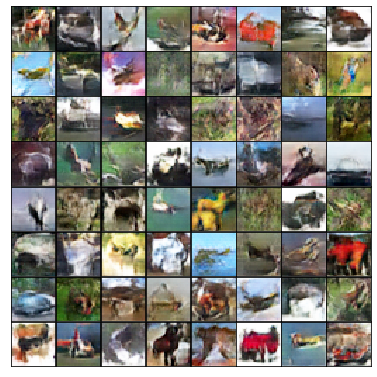

In [85]:
plot_images(g_ims)

In [52]:
np.clip()

(32, 32, 3)